### Simulation

Even in the absence of an experimental setup, ``slmsuite`` is an ideal testbed for new holography algorithms and SLM techniques. Here, we demonstrate the basic simulation features of ``slmsuite`` to investigate the accuracy of the package's wavefront calibration routines.

In [1]:
# Header

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add slmsuite to the python path.
import sys, os
# sys.path.append(os.path.join(os.getcwd(), '../../slmsuite'))
sys.path.append(os.path.join(os.getcwd(), '../../..'))

from slmsuite.hardware.cameraslms import FourierSLM

from slmsuite.holography import toolbox
from slmsuite.holography import analysis
from slmsuite.holography.algorithms import Hologram
from slmsuite.holography.algorithms import SpotHologram

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rc('image', cmap='turbo')

C:\Users\Experiment\Documents\GitHub\slmsuite\docs\slmsuite-examples\examples\../../..\slmsuite\hardware\cameraslms.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### Simulated SLMs

`SimulatedSLM` is a testbed for implementing physical non-idealities of spatial light modulators, including panel curvature (near-field phase distortions), cross-talk/mutual coupling, and non-uniform control value-to-phase shift transduction across the aperture. 

We start by building a `SimulatedSLM` with an arbitary flatness map (using `slmsuite`'s [Zernike functions](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.phase.zernike_sum.html)) and elliptical source illumination.

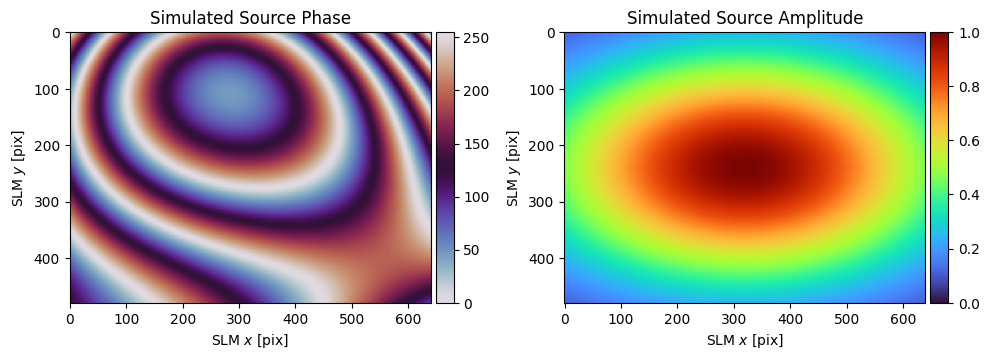

In [2]:
from slmsuite.hardware.slms.simulated import SimulatedSLM

# SLM resolution in pixels
res = (640,480)
bits = 8

#Build an arbitrary flatness map 
dummy_slm = SimulatedSLM(res)
phase_abberation = toolbox.phase.zernike_sum(dummy_slm,
    weights=(((2, 0),  7),       # Z_20
             ((2, 1), -8),       # Z_21
             ((3, 1),  9)),      # Z_31
    aperture="cropped")

# The abberated SLM
slm = SimulatedSLM(res, bitdepth=bits)
slm.set_source_analytic('gaussian2d', x0=0, y0=0, a=1, c=0, wx=0.4, wy=0.3, units="frac",
                         phase_offset = phase_abberation,
                         sim = True)
slm.plot_source(sim=True);

SimulatedSLM's (simulated) ``source`` attribute is independent of the SLM ``phase`` attribute, and is applied whenever ``phase`` is written to the SLM. We can therefore see the true phase profile of the SLM by plotting the ``display`` attribute.

#### Simulated Cameras

``SimulatedCam`` computes the far-field of ``SimulatedSLM`` with desired imaging transformations.

In [3]:
from slmsuite.hardware.cameras.simulated import SimulatedCam

# Option 1: demonstrate the full capability of the simulation mode.
# The simulated camera computes images projected by `slm` with the desired
# affine transformation and noise. Computing the intensity at each
# camera pixel therefore requires (slow) interpolation from the computed
# (and heavily padded) SLM far-field.
# Note that f_eff is in units pix/radian by default.
# Since the max steering angle is O(1 rad), f_eff~slm_res is a good proxy for unity magnification.

cam_res = (512,512)
cam_bits = 14 # Since camera precision typically limits convergence, we'll simulate a low-quanization-noise unit.    
# readout_noise = {'read': lambda img: np.random.poisson(0.01*img)} # Support for readout noise & dark current
cam = SimulatedCam(slm, cam_res, bitdepth=cam_bits)
cam.set_affine(f_eff=1.2*res[0], theta=np.pi/10)

# Option 2: fastest simulation. 
# Directly sample the SLM far-field without transformations since the 
# "ij" and "knm" bases are equivalent.

# cam = SimulatedCam(slm)

Padded SLM k-space shape set to (1024,1024) to achieve required imaging resolution.
Padded SLM k-space shape set to (1024,1024) to achieve required imaging resolution.


C:\Users\Experiment\Documents\GitHub\slmsuite\docs\slmsuite-examples\examples\../../..\slmsuite\hardware\cameras\simulated.py:189: UserWarning: Camera extends beyond the accessible SLM k-space; some pixels may not be targetable.
  warnings.warn(


Also note that since we created this simulated camera without specifying the effective focal length $f_\text{eff}$ between the SLM and camera, `slmsuite` computed the minimum effective focal length $f_\text{min}$ that places the camera fully within the SLM's accesible $k$-space. For more notes on $f_\text{eff}$ see the [`SimulatedCam` documentation](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameras.simulated.html). 

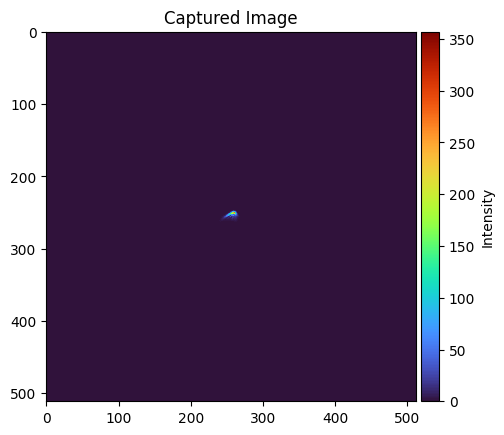

In [4]:
# Take a sample picture
im = cam.get_image(plot=True)

#### Using Simulation to Compare Wavefront Calibration Algorithms

Now that we have simulated SLM/camera pair, we can use ``slmsuite``'s features normally, as if we had an experiment in hand! Here, we'll use simulation mode to check the accuracy of various wavefront calibration techniques.

In [5]:
fs = FourierSLM(cam, slm)

  0%|          | 0/50 [00:00<?, ?it/s]

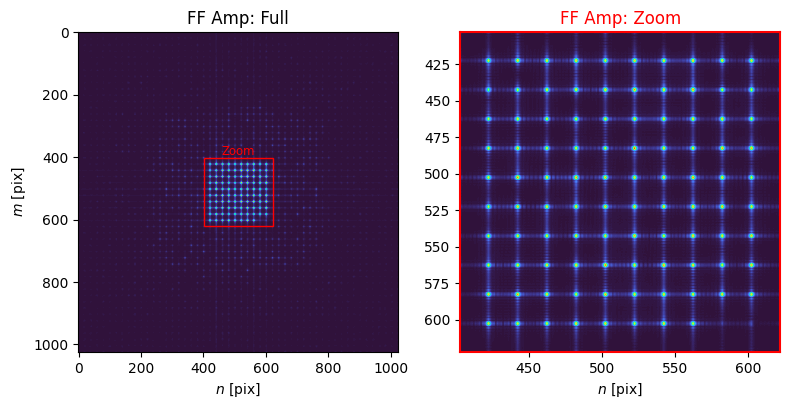

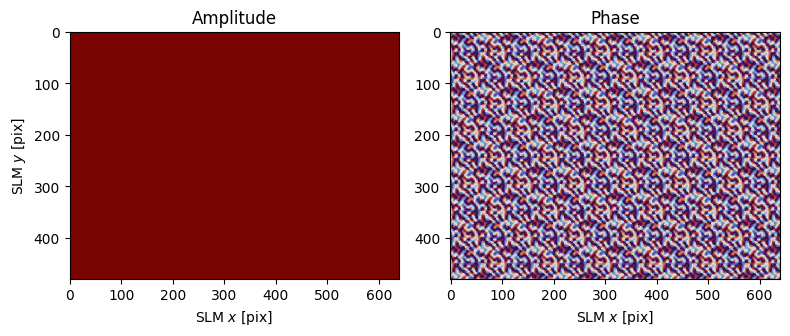

Reset exposure to 2.00s; maximum image value = 12.
Reset exposure to 4.00s; maximum image value = 24.
Reset exposure to 8.00s; maximum image value = 48.
Reset exposure to 16.00s; maximum image value = 96.
Reset exposure to 32.00s; maximum image value = 192.
Reset exposure to 64.00s; maximum image value = 383.
Reset exposure to 128.00s; maximum image value = 766.
Reset exposure to 256.00s; maximum image value = 1533.
Reset exposure to 512.00s; maximum image value = 3066.
Reset exposure to 1024.00s; maximum image value = 6131.
Reset exposure to 1368.23s; maximum image value = 8192.


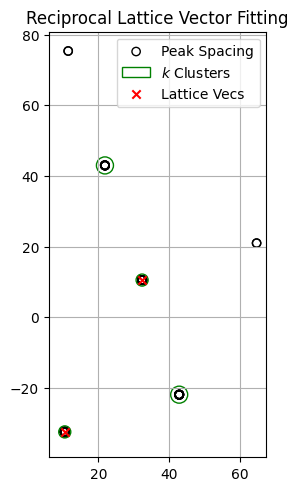

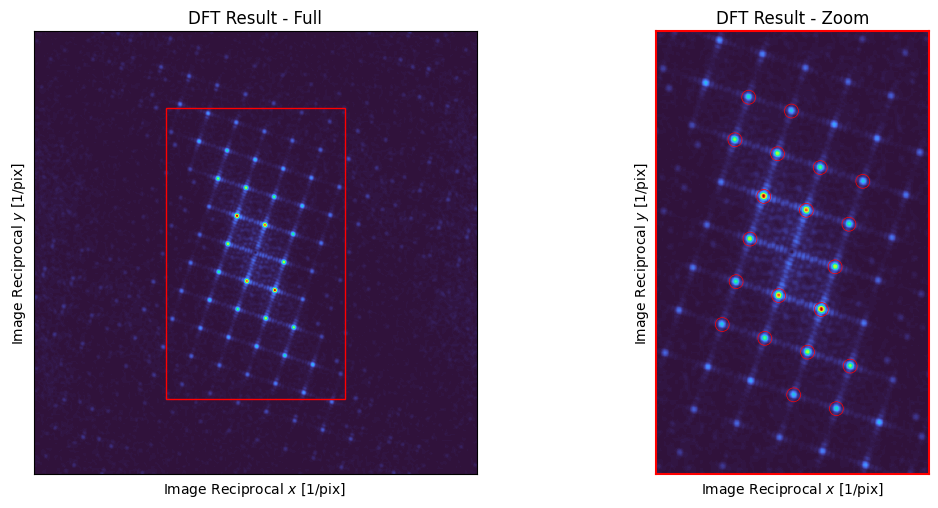

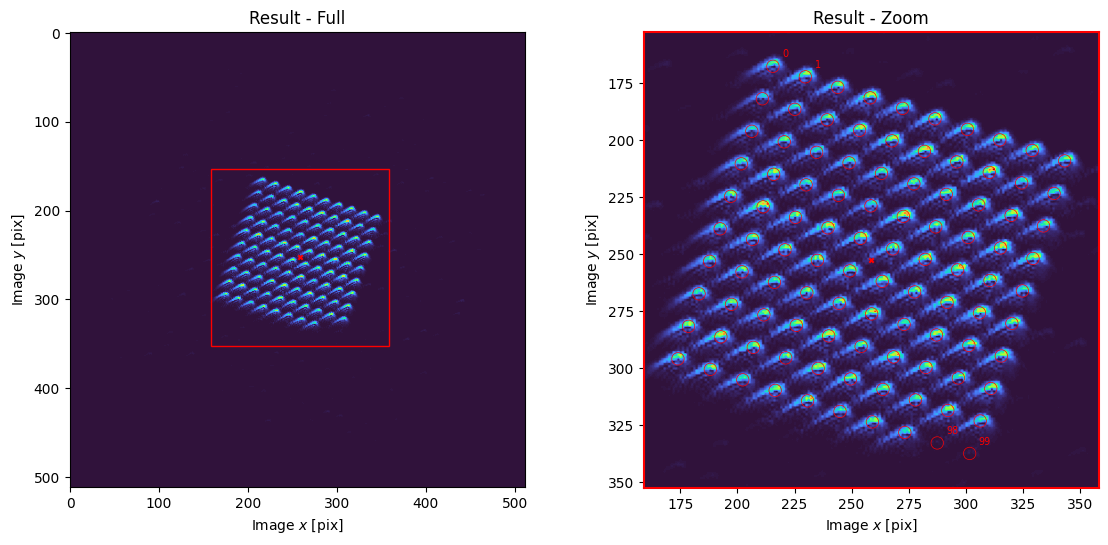

{'M': array([[ 726.64901052, -236.60316689],
       [ 235.72750081,  728.72877373]]), 'b': array([[258.61784386],
       [252.54652068]]), 'a': array([[0.],
       [0.]])}


In [6]:
fs.fourier_calibrate(
    array_shape=[10, 10],           # Size of the calibration grid (Nx, Ny) [knm]
    array_pitch=[20, 20],           # Pitch of the calibration grid (x, y) [knm]
    autoexposure={"set_fraction":0.5},
    plot=True);
print(fs.fourier_calibration)

Once Fourier calibrated, we can wavefront calibrate. We'll use ``phase_steps=1`` first, which minimizes SLM writes by fitting the imaged 2D interference pattern between two superpixels. Let's test a superpixel...

C:\Users\Experiment\Documents\GitHub\slmsuite\docs\slmsuite-examples\examples\../../..\slmsuite\hardware\cameraslms.py:784: UserWarning: Non-resolvable interference fringe period for the given SLM calibration extent. Either exclude more of the SLM or magnify the field on the camera.
  warnings.warn(


Reset exposure to 2736.46s; maximum image value = 1012.
Reset exposure to 5472.91s; maximum image value = 2023.
Reset exposure to 10945.83s; maximum image value = 4047.
Reset exposure to 21891.65s; maximum image value = 8094.


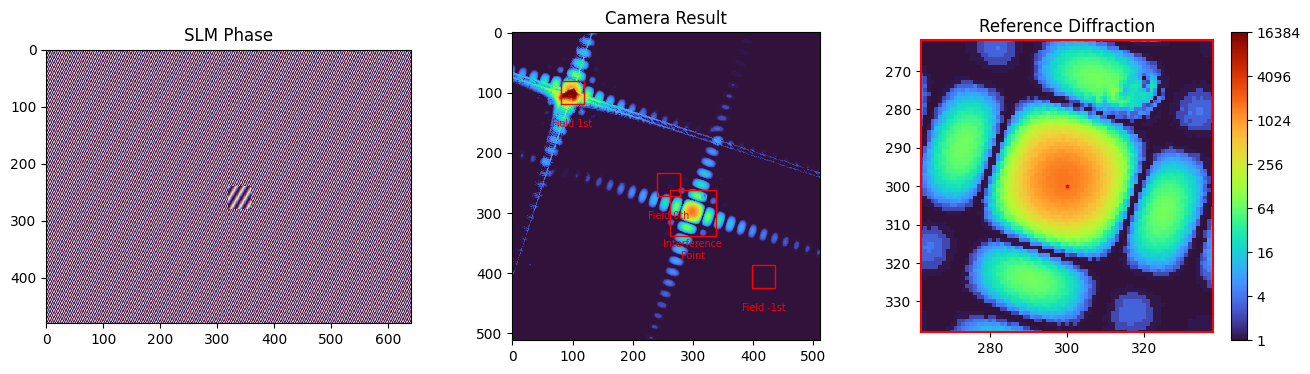

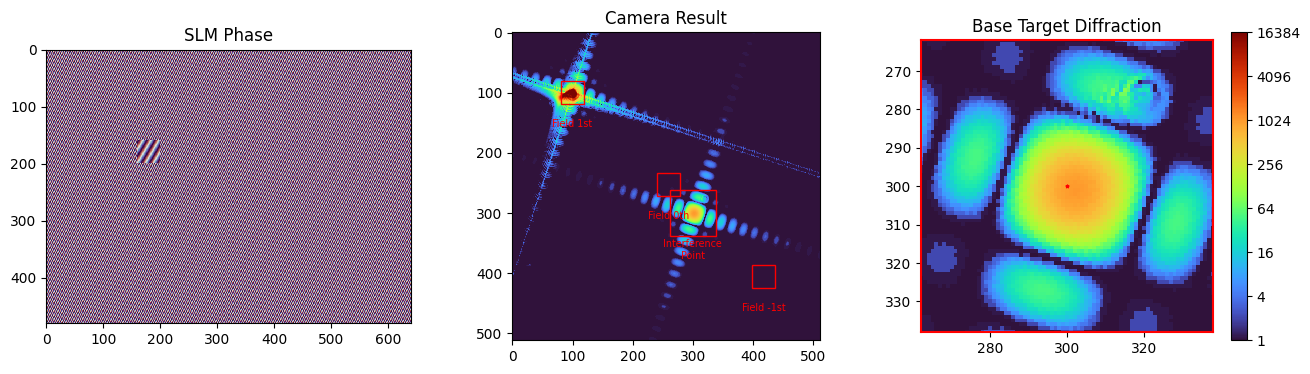

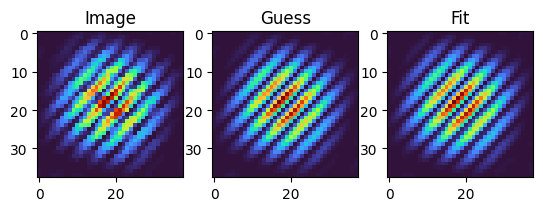

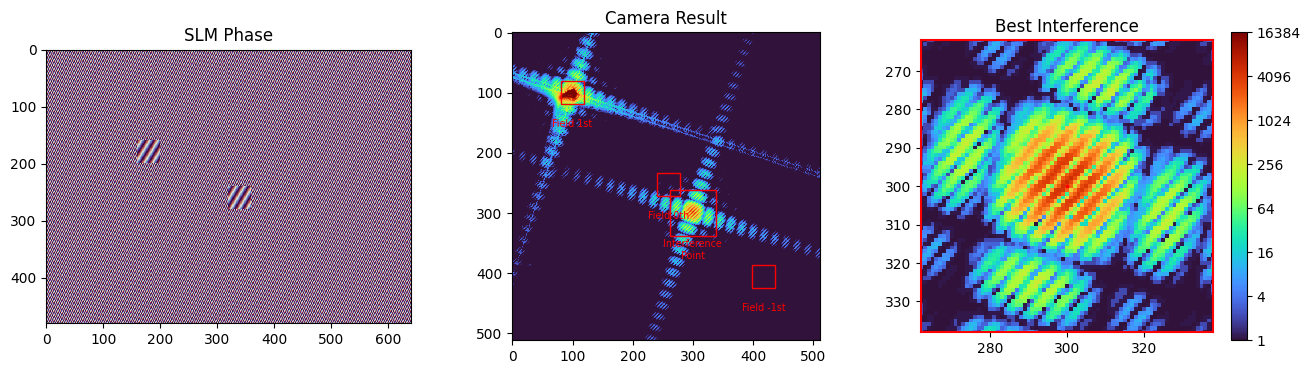

In [7]:
fs.wavefront_calibrate(
    interference_point=(300, 300),
    field_point=(100, 100),
    field_point_units="ij",
    superpixel_size=40,
    phase_steps=1,
    test_superpixel=(4,4),
    plot=True,
    autoexposure=True);

Looks good -- let's calibrate!

In [8]:
fs.wavefront_calibrate(
    interference_point=(300, 300),
    field_point=(100, 100),
    field_point_units="ij",
    superpixel_size=40,
    phase_steps=1,
    plot=False,
    autoexposure=True);

Reset exposure to 8756.66s; maximum image value = 3238.
Reset exposure to 17513.32s; maximum image value = 6475.
Reset exposure to 22157.40s; maximum image value = 8192.


calibration:   0%|          | 0/192 [00:00<?, ?it/s]

C:\Users\Experiment\Documents\GitHub\slmsuite\docs\slmsuite-examples\examples\../../..\slmsuite\hardware\cameraslms.py:1062: UserWarning: Image fitting failed; nulling response from this superpixel.
  warnings.warn("Image fitting failed; nulling response from this superpixel.")
C:\Users\Experiment\Documents\GitHub\slmsuite\docs\slmsuite-examples\examples\../../..\slmsuite\hardware\cameraslms.py:1068: RuntimeWarning: invalid value encountered in scalar divide
  contrast = np.abs(popt[1] / (np.abs(popt[1]) + np.abs(popt[3])))
C:\Users\Experiment\Documents\GitHub\slmsuite\docs\slmsuite-examples\examples\../../..\slmsuite\misc\fitfunctions.py:346: RuntimeWarning: divide by zero encountered in scalar divide
  return np.square(np.sinc((1 / R) * x) * np.sinc((1 / R) * y)) \
C:\ProgramData\Anaconda3\envs\slmsuite\Lib\site-packages\numpy\lib\function_base.py:3639: RuntimeWarning: invalid value encountered in sin
  return sin(y)/y


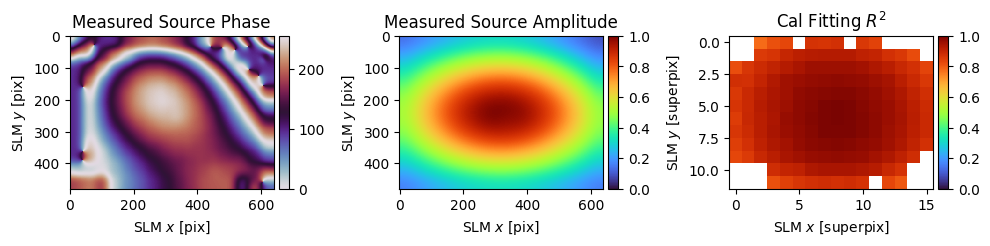

In [9]:
wavefront_cal = fs.process_wavefront_calibration(r2_threshold=.9, smooth=True, plot=True)

The phase pattern is smooth in the center but the fitting error increases around the panel edges where the illumination amplitude also drops off. The amplitude appears to be spot on (.. no pun intended ..). The real question is -- how does the computed flatness map compare to the true phase error?

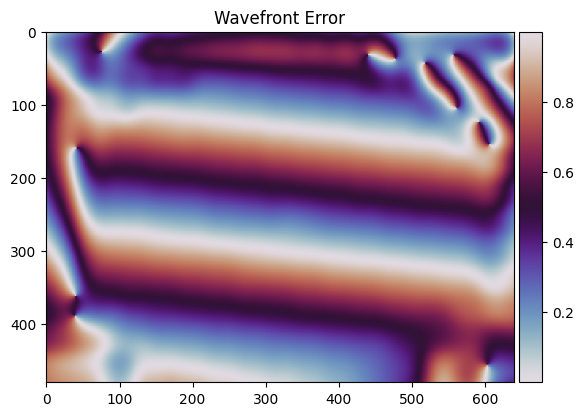

In [10]:
phase_corrected = np.mod(slm.source["phase"]+slm.source["phase_sim"], 2*np.pi)

fig, ax = plt.subplots(1,1)
im = ax.imshow(phase_corrected/(2*np.pi),
               cmap=plt.get_cmap("twilight"),
               interpolation="none")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('Wavefront Error');

Qualitatively, we're (primarily) left with a residual blaze where the fitting was good. This makes sense, as any linear phase ramp in the true flatness map is effectively projected out (i.e. corrected) by **Fourier** calibration which calculates and compensates for the resulting spot translation. 

Quantiatively, how good did we do? To find out, let's try a hologram and compute some spot metrics.

C:\Users\Experiment\Documents\GitHub\slmsuite\docs\slmsuite-examples\examples\../../..\slmsuite\holography\algorithms.py:325: UserWarning: algorithms.py: Hologram target shape (480, 640) is not a power of 2; consider using .calculate_padded_shape() to pad to powers of 2 and speed up FFT computation. While some FFT solvers support other prime powers (3, 5, 7, ...), literature suggests that GPU support is best for powers of 2.
  warnings.warn(


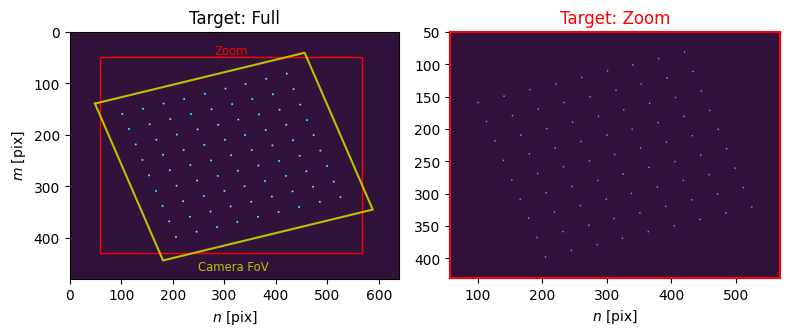

[array([ 58, 568], dtype=int64), array([ 50, 431], dtype=int64)]

In [11]:
# Make the desired hologram: a grid of points on the camera
xlist = np.arange(50, cam.shape[1]-50, 50)                    
ylist = np.arange(50,cam.shape[0]-50,50)
xgrid, ygrid = np.meshgrid(xlist, ylist)
square = np.vstack((xgrid.ravel(), ygrid.ravel()))

hologram = SpotHologram(shape=slm.shape, spot_vectors=square, basis='ij', cameraslm=fs)
hologram.plot_farfield(hologram.target, title="Target")

In [12]:
# Callback function: set camera exposure and center spots during first few WGS iterations
def tweaks(holo):
    if holo.iter == 0:
        cam.autoexposure(0.8)
    if holo.iter < 2:
        holo.refine_offset()
    return False

# Run WGS for 50 iterations; fix the far-field phase after 10 iterations
hologram.optimize(
    'WGS-Kim',
    maxiter=50,
    callback = tweaks,
    fix_phase_iteration=10,
    feedback='experimental_spot',
    stat_groups=['computational_spot', 'experimental_spot'])

  0%|          | 0/50 [00:00<?, ?it/s]

Reset exposure to 2215.74s; maximum image value = 16384.
Reset exposure to 1107.87s; maximum image value = 16384.
Reset exposure to 553.93s; maximum image value = 16384.
Reset exposure to 276.97s; maximum image value = 16384.
Reset exposure to 138.48s; maximum image value = 16384.
Reset exposure to 69.24s; maximum image value = 16384.
Reset exposure to 34.62s; maximum image value = 11107.
Reset exposure to 25.53s; maximum image value = 8192.


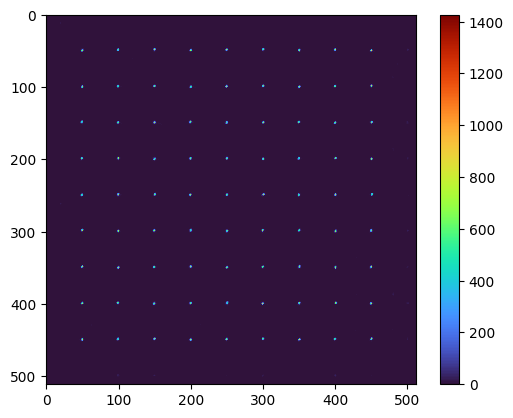

In [13]:
plt.imshow(cam.get_image())
plt.colorbar()

Now let's visualize the results and calculate a few statistics for comparison.

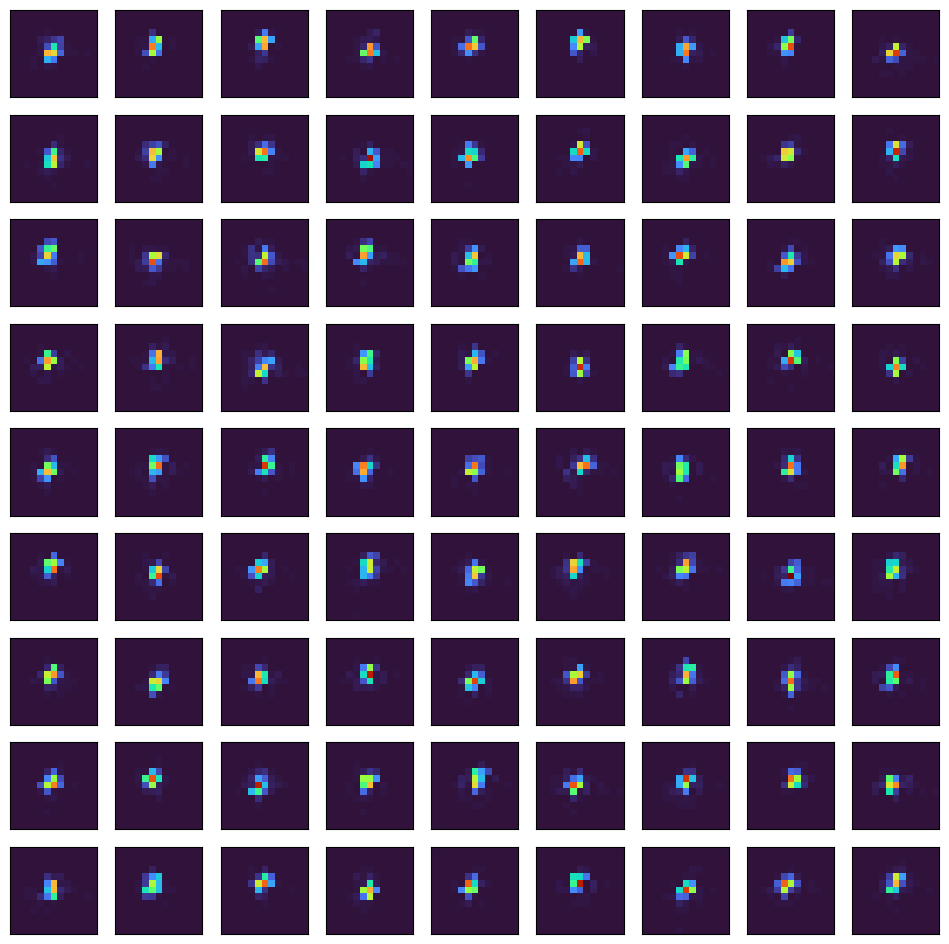

Spot center = (-0.288,-0.570) +/- (0.115,0.214) px
Spot skew = 0.094 +/- 0.300 px


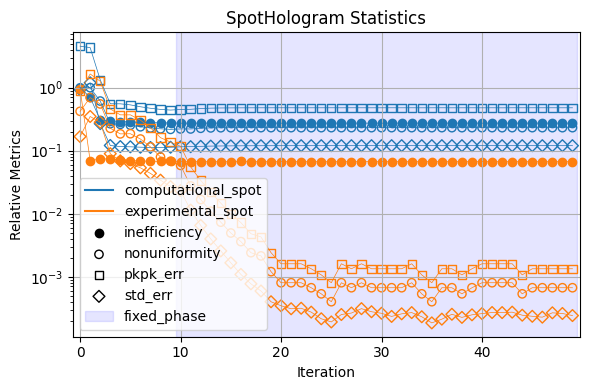

In [14]:
img = cam.get_image()                                        
subimages = analysis.take(img, square, hologram.spot_integration_width_ij)
analysis.take_plot(subimages)
power = analysis.image_normalization(np.array(subimages, dtype=np.float32))
hologram.plot_stats()

# Calculate a few statistics
pos = analysis.image_moment(subimages,moment=(1,0)), analysis.image_moment(subimages,moment=(0,1))
print(r"Spot center = (%1.3f,%1.3f) +/- (%1.3f,%1.3f) px"%(np.mean(pos[0]),np.mean(pos[1]),np.var(pos[0]),np.var(pos[1])))
shape = analysis.image_moment(subimages,moment=(1,1))
print(r"Spot skew = %1.3f +/- %1.3f px"%(np.mean(shape),np.var(shape)**0.5))

Peak-to-peak power uniformity bottoms out ~$10^{-3}$. Lets compare the other stats to those generated using: 1) wavefront calibration using ``phase_steps>1``; and 2) perfect wavefront calibration.

In [15]:
#1) phase_steps=10
fs.wavefront_calibrate(
    interference_point=(300, 300),
    field_point=(800, 500),
    field_point_units="ij",
    superpixel_size=40,
    phase_steps=10,
    plot=False,
    autoexposure=True);

C:\Users\Experiment\Documents\GitHub\slmsuite\docs\slmsuite-examples\examples\../../..\slmsuite\hardware\cameraslms.py:784: UserWarning: Non-resolvable interference fringe period for the given SLM calibration extent. Either exclude more of the SLM or magnify the field on the camera.
  warnings.warn(


Reset exposure to 81.71s; maximum image value = 30.
Reset exposure to 163.42s; maximum image value = 61.
Reset exposure to 326.85s; maximum image value = 121.
Reset exposure to 653.69s; maximum image value = 242.
Reset exposure to 1307.38s; maximum image value = 484.
Reset exposure to 2614.76s; maximum image value = 968.
Reset exposure to 5229.52s; maximum image value = 1936.
Reset exposure to 10459.04s; maximum image value = 3872.
Reset exposure to 20918.08s; maximum image value = 7745.


calibration:   0%|          | 0/192 [00:00<?, ?it/s]

superpixel=(0,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,11):   0%|          | 0/10 [00:00<?, ?it/s]

The calibration took ~2x longer (and with ~10x more calls to the SLM, which would actually dominate calibration time in an experiment); how did it perform?

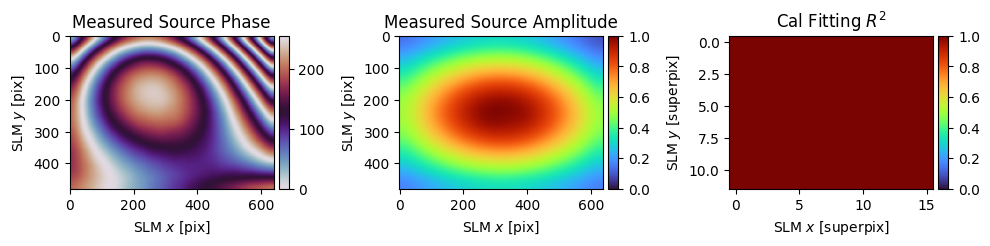

In [16]:
wavefront_cal = fs.process_wavefront_calibration(r2_threshold=.9, smooth=True, plot=True)

So the result is cleaner, but does better fitting mean better spots? Let's see...

In [17]:
#Redo Fourier cal
fs.fourier_calibrate(
    array_shape=[10, 10],           # Size of the calibration grid (Nx, Ny) [knm]
    array_pitch=[20, 20],           # Pitch of the calibration grid (x, y) [knm]
    plot=False)

  0%|          | 0/50 [00:00<?, ?it/s]

{'M': array([[ 730.46648446, -237.01203541],
        [ 237.0550149 ,  730.29917439]]),
 'b': array([[258.41746582],
        [252.57378025]]),
 'a': array([[0.],
        [0.]])}

In [18]:
hologram = SpotHologram(shape=slm.shape, spot_vectors=square, basis='ij', cameraslm=fs)
hologram.optimize(
    'WGS-Kim',
    maxiter=50,
    callback = tweaks,
    fix_phase_iteration=10,
    feedback='experimental_spot',
    stat_groups=['computational_spot', 'experimental_spot'])

C:\Users\Experiment\Documents\GitHub\slmsuite\docs\slmsuite-examples\examples\../../..\slmsuite\holography\algorithms.py:325: UserWarning: algorithms.py: Hologram target shape (480, 640) is not a power of 2; consider using .calculate_padded_shape() to pad to powers of 2 and speed up FFT computation. While some FFT solvers support other prime powers (3, 5, 7, ...), literature suggests that GPU support is best for powers of 2.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Reset exposure to 2091.81s; maximum image value = 16384.
Reset exposure to 1045.90s; maximum image value = 16384.
Reset exposure to 522.95s; maximum image value = 16384.
Reset exposure to 261.48s; maximum image value = 10827.
Reset exposure to 197.84s; maximum image value = 8192.


Spot center = (0.005,-0.099) +/- (0.113,0.201) px
Spot skew = -0.067 +/- 0.165 px


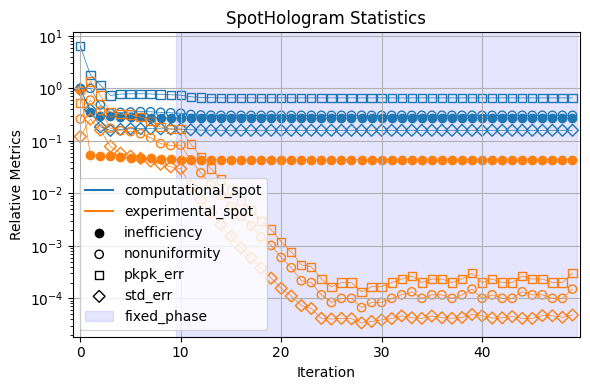

In [19]:
img = cam.get_image()                                        
subimages = analysis.take(img, square, hologram.spot_integration_width_ij)
power = analysis.image_normalization(np.array(subimages, dtype=np.float32))
# plt.hist(power / np.mean(power)); plt.show()
hologram.plot_stats()

# Calculate a few statistics
pos = analysis.image_moment(subimages,moment=(1,0)), analysis.image_moment(subimages,moment=(0,1))
print(r"Spot center = (%1.3f,%1.3f) +/- (%1.3f,%1.3f) px"%(np.mean(pos[0]),np.mean(pos[1]),np.var(pos[0]),np.var(pos[1])))
shape = analysis.image_moment(subimages,moment=(1,1))
print(r"Spot skew = %1.3f +/- %1.3f px"%(np.mean(shape),np.var(shape)**0.5))

The spot centering, skew, and uniformity are a *bit* better. How about perfect wavefront calibration?

In [20]:
# Perfect calibration: set measured to simulated values
slm.source["phase"] = -slm.source["phase_sim"]
slm.source["amplitude"] = slm.source["amplitude_sim"]

In [21]:
#Redo Fourier cal
fs.fourier_calibrate(
    array_shape=[10, 10],           # Size of the calibration grid (Nx, Ny) [knm]
    array_pitch=[20, 20],           # Pitch of the calibration grid (x, y) [knm]
    plot=False)

  0%|          | 0/50 [00:00<?, ?it/s]

{'M': array([[ 730.60283429, -237.32275852],
        [ 236.99233331,  730.42669537]]),
 'b': array([[255.99969748],
        [255.99601209]]),
 'a': array([[0.],
        [0.]])}

In [22]:
hologram = SpotHologram(shape=slm.shape, spot_vectors=square, basis='ij', cameraslm=fs)
hologram.optimize(
    'WGS-Kim',
    maxiter=50,
    callback = tweaks,
    fix_phase_iteration=10,
    feedback='experimental_spot',
    stat_groups=['computational_spot', 'experimental_spot'])

C:\Users\Experiment\Documents\GitHub\slmsuite\docs\slmsuite-examples\examples\../../..\slmsuite\holography\algorithms.py:325: UserWarning: algorithms.py: Hologram target shape (480, 640) is not a power of 2; consider using .calculate_padded_shape() to pad to powers of 2 and speed up FFT computation. While some FFT solvers support other prime powers (3, 5, 7, ...), literature suggests that GPU support is best for powers of 2.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Reset exposure to 158.27s; maximum image value = 8564.


Spot center = (0.015,-0.088) +/- (0.119,0.184) px
Spot skew = -0.081 +/- 0.168 px


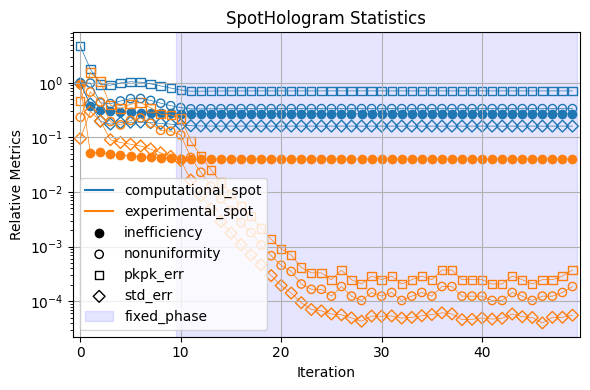

In [23]:
img = cam.get_image()                                        
subimages = analysis.take(img, square, hologram.spot_integration_width_ij)
power = analysis.image_normalization(np.array(subimages, dtype=np.float32))
# plt.hist(power / np.mean(power)); plt.show()
hologram.plot_stats()

# Calculate a few statistics
pos = analysis.image_moment(subimages,moment=(1,0)), analysis.image_moment(subimages,moment=(0,1))
print(r"Spot center = (%1.3f,%1.3f) +/- (%1.3f,%1.3f) px"%(np.mean(pos[0]),np.mean(pos[1]),np.var(pos[0]),np.var(pos[1])))
shape = analysis.image_moment(subimages,moment=(1,1))
print(r"Spot skew = %1.3f +/- %1.3f px"%(np.mean(shape),np.var(shape)**0.5))

Not much different. So both wavefront calibration routines work well (the single point calibration can also be improved by reducing the lower bound for acceptable values of $R^2$ fitting quality). As we continue to develop `slmsuite`, we plan to introduce additional wavefront calibration routines along with better metrics (e.g., Strehl ratio) to study their performance. 

#### Cloning an Experiment into Simulation

Another neat feature of simulation mode is the ability to easily clone an experiment into simulation, thus creating a "digital twin" that can be used to compare observed and ideal performance.

In [24]:
from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.cameras.alliedvision import AlliedVision

Santec slm_number=1 initializing... success
Looking for display_number=2... success
Opening LCOS-SLM,SOC,8001,2018021001... success
vimba initializing... success
Looking for cameras... success
vimba sn 02C5V initializing... success


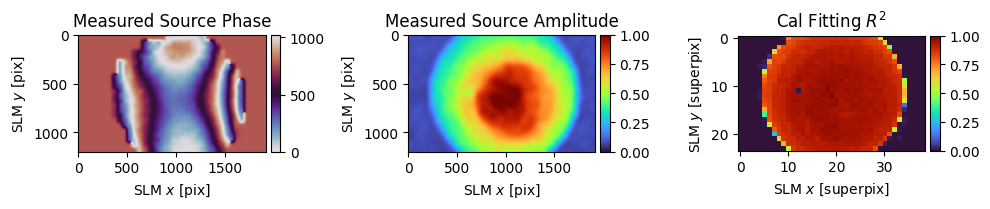

In [25]:
slm = Santec(slm_number=1, display_number=2, wav_um=.633, settle_time_s=.3)
cam = AlliedVision(serial="02C5V", verbose=True)
fs = FourierSLM(cam, slm)
fs.load_wavefront_calibration(plot=True);

  0%|          | 0/50 [00:00<?, ?it/s]

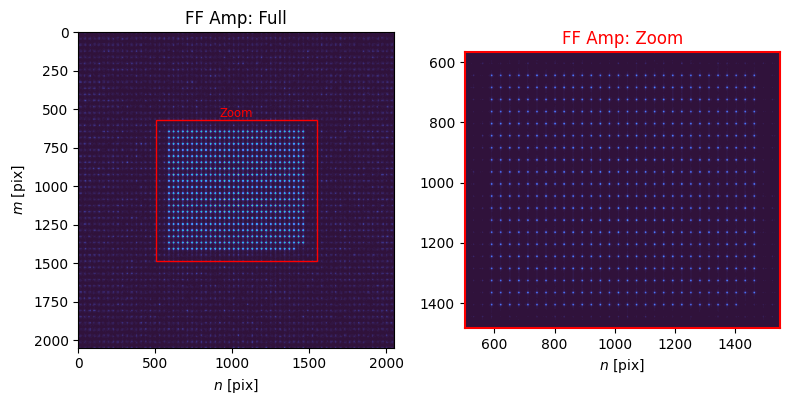

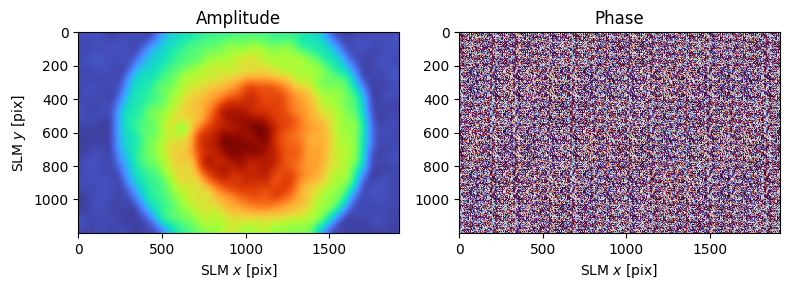

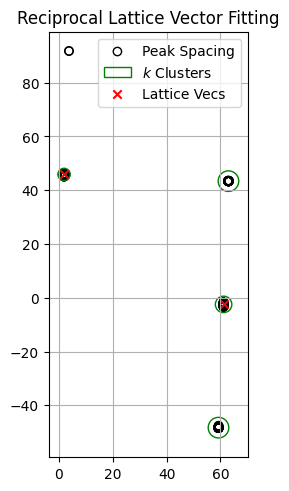

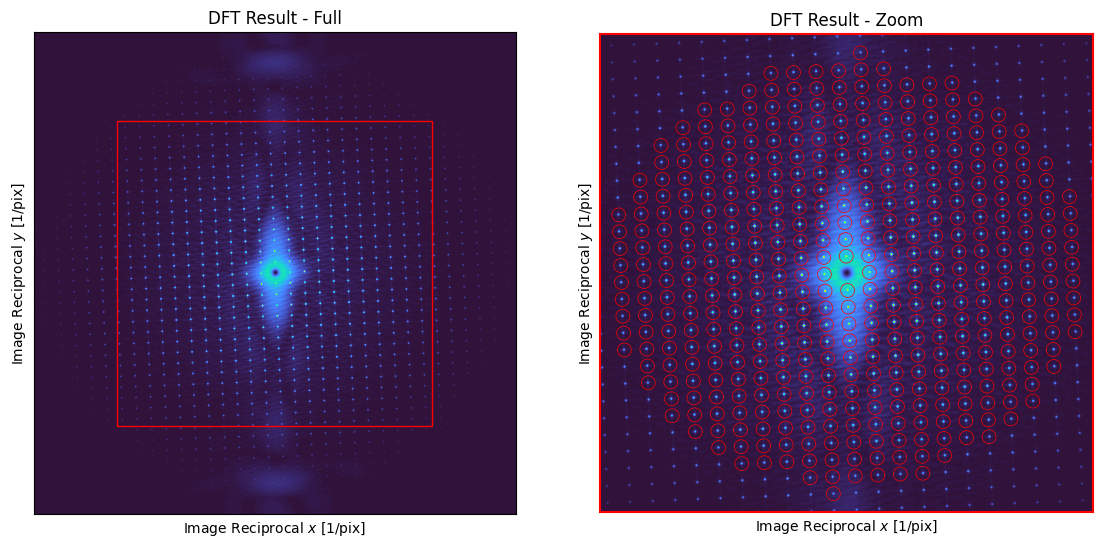

C:\Users\Experiment\Documents\GitHub\slmsuite\docs\slmsuite-examples\examples\../../..\slmsuite\holography\analysis.py:1493: UserWarning: The fitted spot array approaches or exceeds the camera FOV; calibration results may be improperly centered as a result.
  warnings.warn(


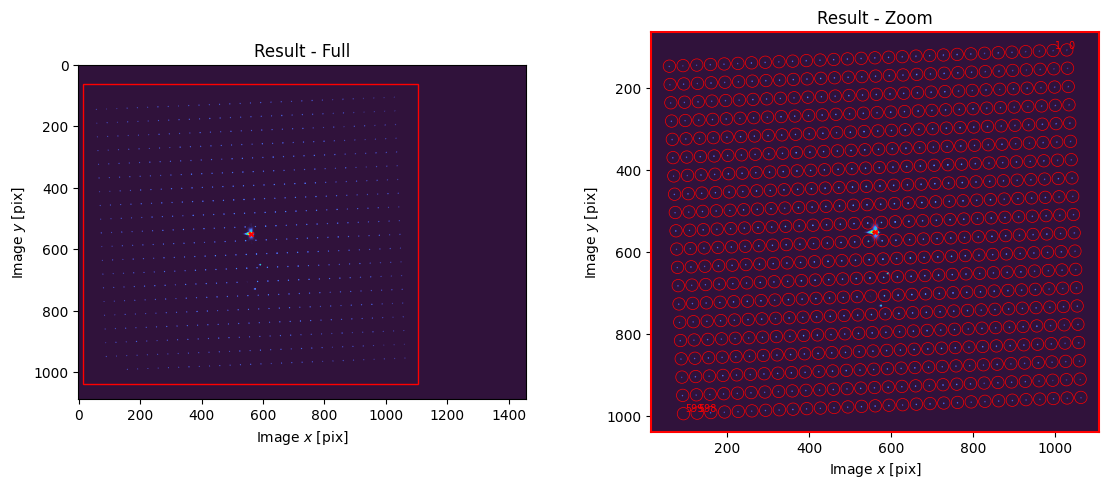

{'M': array([[-28824.69275653,   1168.11665108],
        [  1180.32581075,  28853.27802505]]),
 'b': array([[560.31675049],
        [550.49759045]]),
 'a': array([[-1.16424394e-20],
        [ 7.45116124e-19]])}

In [26]:
cam.set_exposure(0.01)
fs.fourier_calibrate(
    array_shape=[30, 20],           # Size of the calibration grid (Nx, Ny) [knm]
    array_pitch=[30, 40],           # Pitch of the calibration grid (x, y) [knm]
    plot=True
)

After Fourier and wavefront calibration, we can run a clean hardware-based experiment.

C:\Users\Experiment\Documents\GitHub\slmsuite\docs\slmsuite-examples\examples\../../..\slmsuite\holography\algorithms.py:325: UserWarning: algorithms.py: Hologram target shape (1200, 1920) is not a power of 2; consider using .calculate_padded_shape() to pad to powers of 2 and speed up FFT computation. While some FFT solvers support other prime powers (3, 5, 7, ...), literature suggests that GPU support is best for powers of 2.
  warnings.warn(


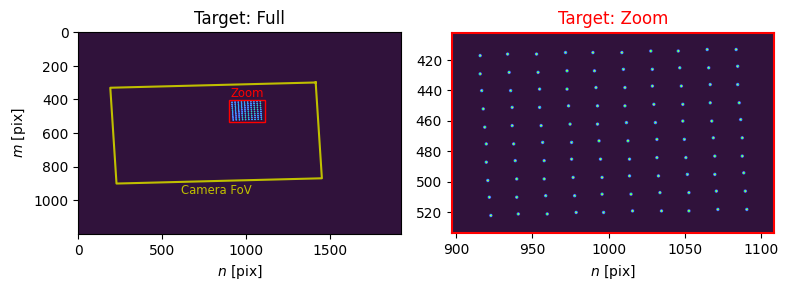

[array([ 897, 1109], dtype=int64), array([402, 534], dtype=int64)]

In [27]:
xlist = np.linspace(400, 600, 10)               
ylist = np.linspace(200, 400, 10)
xgrid, ygrid = np.meshgrid(xlist, ylist)
square = np.vstack((xgrid.ravel(), ygrid.ravel()))

hologram = SpotHologram(shape=slm.shape, spot_vectors=square, basis='ij', cameraslm=fs)
hologram.plot_farfield(hologram.target, title="Target")

  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\Experiment\Documents\GitHub\slmsuite\docs\slmsuite-examples\examples\../../..\slmsuite\holography\algorithms.py:1327: RuntimeWarning: divide by zero encountered in divide
  feedback_pwr *= 1 / feedback_pwr_sum
C:\Users\Experiment\Documents\GitHub\slmsuite\docs\slmsuite-examples\examples\../../..\slmsuite\holography\algorithms.py:1327: RuntimeWarning: invalid value encountered in multiply
  feedback_pwr *= 1 / feedback_pwr_sum
C:\Users\Experiment\Documents\GitHub\slmsuite\docs\slmsuite-examples\examples\../../..\slmsuite\holography\algorithms.py:1328: RuntimeWarning: divide by zero encountered in divide
  feedback_amp *= 1 / xp.sqrt(feedback_pwr_sum)
C:\Users\Experiment\Documents\GitHub\slmsuite\docs\slmsuite-examples\examples\../../..\slmsuite\holography\algorithms.py:1328: RuntimeWarning: invalid value encountered in multiply
  feedback_amp *= 1 / xp.sqrt(feedback_pwr_sum)


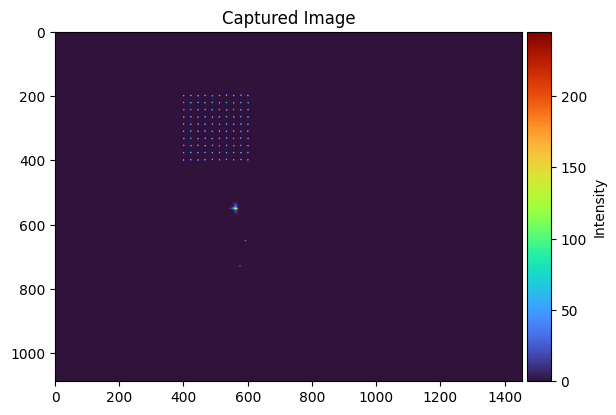

Text(0.5, 1.0, 'Experimental Convergence')

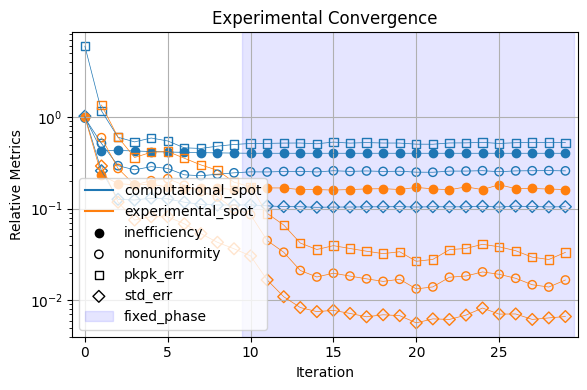

In [28]:
cam.set_exposure(0.004)

hologram.optimize(
    'WGS-Kim',
    maxiter=30,
    fix_phase_iteration=10,
    feedback='experimental_spot',
    stat_groups=['computational_spot', 'experimental_spot'])

cam.get_image(plot=True)
ax = hologram.plot_stats()
ax.set_title('Experimental Convergence')

We can easily compare the results to ideal performance using ``slmsuite``'s simulation features. The ``simulate`` method of ``FourierSLM`` creates simulated replicas of the camera and SLM and orients them according to the measured Fourier calibration.

In [29]:
fs_sim = fs.simulate()

Padded SLM k-space shape set to (4096,4096) to achieve required imaging resolution.


  0%|          | 0/30 [00:00<?, ?it/s]

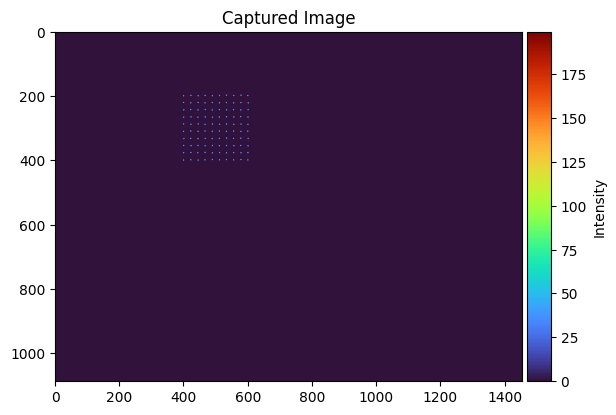

Text(0.5, 1.0, 'Simulated Convergence')

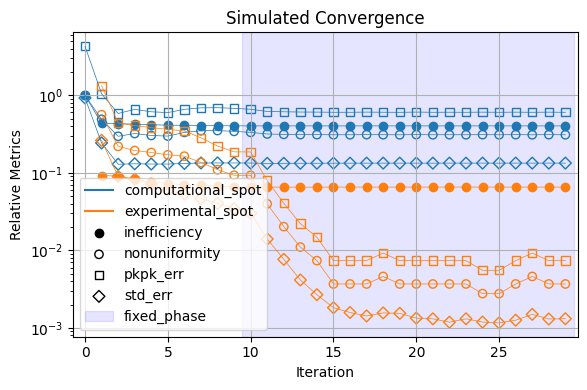

In [31]:
hologram_sim = SpotHologram(shape=fs_sim.slm.shape, spot_vectors=square, basis='ij', cameraslm=fs_sim)
fs_sim.cam.set_exposure(800)

hologram_sim.optimize(
    'WGS-Kim',
    maxiter=30,
    fix_phase_iteration=10,
    feedback='experimental_spot',
    stat_groups=['computational_spot', 'experimental_spot'])

fs_sim.cam.get_image(plot=True)
ax = hologram_sim.plot_stats()
ax.set_title('Simulated Convergence')

We can now see that the experimental convergence is slightly worse than the camera-bit-depth-limited (simulated) performance. We can now use ``slmsuite`` to hunt down the source of the discrepancy. 